<a href="https://colab.research.google.com/github/Rama-Has/Poem_Generator_Rama_Hasiba_12010022/blob/main/English_Poem_Generator_NLP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Sections: 
  1. Fine tune a gpt-2 model. 

## Importing Libraries

In [77]:
# !pip install transformers==4.28.0
# !pip install git+https://github.com/huggingface/transformers
# !pip install --upgrade transformers
# !pip install transformers

In [2]:
# !pip install tensorflow

In [36]:
from google.colab import files
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.models import load_model 
from google.colab import drive 
from tensorflow.keras.utils import to_categorical
from transformers import GPT2LMHeadModel, GPT2Tokenizer#take the input text then encode it from text to numbers
from sklearn.model_selection import train_test_split
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments, AutoModelWithLMHead
from transformers import pipeline
import shutil

# Reading Data
-------------------

In [4]:
#mount google drive to the colab runtime
drive.mount('/content/drive') 

Mounted at /content/drive


In [9]:
csv_data = pd.read_csv('/content/drive/MyDrive/Classroom/merged_data.csv') 

In [10]:
csv_data

,Unnamed: 0,Verse,Meter,char_count
0,0,ah why this boding start this sudden pain,iambic,6
1,1,that wings my pulse and shoots from vein to vein,iambic,6
2,2,what mean regardless of yon midnight bell,iambic,6
3,3,these earthborn visions saddening o'er my cell,iambic,6
4,4,what strange disorder prompts these thoughts t...,iambic,6
...,...,...,...,...
198997,202272,were mellow music matchd with him,iambic,6
198998,202274,o life as futile then as frail,iambic,6
198999,202275,o for thy voice to soothe and bless,iambic,6
199000,202276,what hope of answer or redress,iambic,6


The dataset consists of 4 columns, we are interested on the "Verse" one only. It contains 199002 sample(verse), I decided to train the model with 16000 sample due to the resource limitation I have.

In [11]:
csv_data = csv_data[['Verse']]

In [12]:
csv_data  

,Verse
0,ah why this boding start this sudden pain
1,that wings my pulse and shoots from vein to vein
2,what mean regardless of yon midnight bell
3,these earthborn visions saddening o'er my cell
4,what strange disorder prompts these thoughts t...
...,...
198997,were mellow music matchd with him
198998,o life as futile then as frail
198999,o for thy voice to soothe and bless
199000,what hope of answer or redress


## Preparing the Corpus

In [13]:
corpus = csv_data['Verse'].to_list()[0: 16000]

In [14]:
corpus[0: 4]

['ah why this boding start this sudden pain',
 'that wings my pulse and shoots from vein to vein',
 'what mean regardless of yon midnight bell',
 "these earthborn visions saddening o'er my cell"]

Get the length of each verse, where length represent number of words in that verse 


In [15]:
verse_length = [len(line.split(' ')) for line in corpus]
verse_length[0: 5]   

[8, 10, 7, 7, 8]

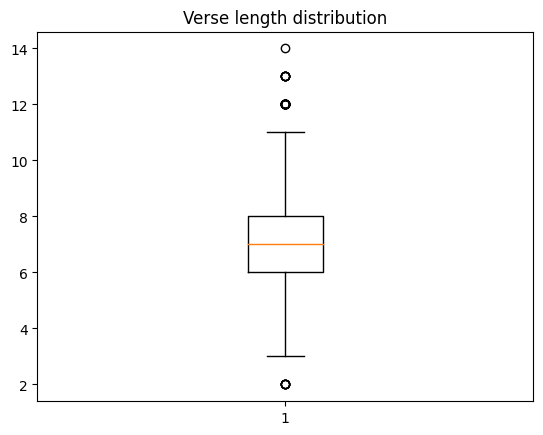

In [16]:
plt.boxplot(verse_length)
plt.title('Verse length distribution')
plt.show()

In [17]:
print(
    f'Longest verse has {max(verse_length)} word.'
    f'\nShorter one has {min(verse_length)}.' 
    f'\n{int(np.mean(verse_length))} is the mean number of words per verse.\n' 
)

Longest verse has 14 word.
Shorter one has 2.
7 is the mean number of words per verse.



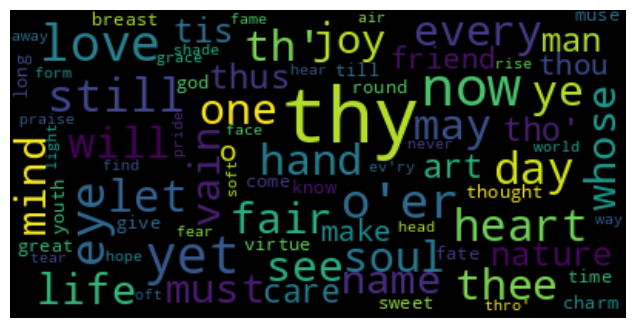

In [18]:
# Generating the wordCloud to visiualize the text
wordcloud = WordCloud(max_font_size=50,
                      max_words=80,
                      background_color="black").generate(" ".join(corpus))
 
# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

#### Text Preprocessing

Making samples, that I'll use in the training, consistant by converting letters to lower case.

> 1. Convert to lower case

In [19]:
corpus = [sentence.lower() for sentence in corpus]

### Tokenizing Data

Tokenize the text using tensorflow tokenizer.

In [20]:
#fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()

#fit the tokenizer on verses, where each word will be assigned to an integer.
tokenizer.fit_on_texts(corpus)

In [21]:
# help(tokenizer)

In [22]:
# Tokenized words
tokenizer.word_index

{'the': 1,
 'and': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'a': 6,
 'with': 7,
 'his': 8,
 'her': 9,
 'that': 10,
 'my': 11,
 'i': 12,
 'thy': 13,
 'from': 14,
 'all': 15,
 'for': 16,
 'but': 17,
 'he': 18,
 'their': 19,
 'on': 20,
 'as': 21,
 'or': 22,
 'by': 23,
 'when': 24,
 'no': 25,
 'not': 26,
 'is': 27,
 'be': 28,
 'you': 29,
 'at': 30,
 'your': 31,
 'they': 32,
 'who': 33,
 'what': 34,
 'this': 35,
 'shall': 36,
 'she': 37,
 'was': 38,
 'nor': 39,
 'so': 40,
 'now': 41,
 'where': 42,
 'me': 43,
 'it': 44,
 'yet': 45,
 'more': 46,
 'can': 47,
 'then': 48,
 'each': 49,
 'which': 50,
 'are': 51,
 "o'er": 52,
 'our': 53,
 'if': 54,
 'while': 55,
 'love': 56,
 'still': 57,
 'we': 58,
 'like': 59,
 'let': 60,
 'how': 61,
 'him': 62,
 'there': 63,
 'its': 64,
 'thou': 65,
 'every': 66,
 "th'": 67,
 'thee': 68,
 'some': 69,
 'fair': 70,
 'heart': 71,
 'will': 72,
 'see': 73,
 'too': 74,
 'these': 75,
 'an': 76,
 'here': 77,
 'soul': 78,
 'may': 79,
 'such': 80,
 'one': 81,
 'day': 82,
 'ye':

In [23]:
# vocabulary count of the corpus
number_of_words = len(tokenizer.word_index)
 
print(f"number of words:\n {number_of_words}")

number of words:
 13453


#### Pickling the tokenizer

In [24]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



-----------------------------
# GPT-2 Fine Tunning

In [38]:
df = pd.DataFrame(corpus, columns = ['verse'])
df

,verse
0,ah why this boding start this sudden pain
1,that wings my pulse and shoots from vein to vein
2,what mean regardless of yon midnight bell
3,these earthborn visions saddening o'er my cell
4,what strange disorder prompts these thoughts t...
...,...
15995,for ever lives the particle divine
15996,yet make myy tomb to future ages known
15997,and with a modest verse inscribe the stone
15998,the verse shall preach some moral truth to man


In [39]:
df.to_csv(
    r'full_text.txt', 
    header=None, 
    index=None, 
    sep=' ',
    mode='a'
    )

### Load the GPT Model
GPT-2

In [42]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id = gpt_tokenizer.eos_token_id)

In [43]:
gpt_tokenizer.decode(gpt_tokenizer.eos_token_id)

'<|endoftext|>'

# Tokenizing

In [44]:
corpus[:5]

['ah why this boding start this sudden pain',
 'that wings my pulse and shoots from vein to vein',
 'what mean regardless of yon midnight bell',
 "these earthborn visions saddening o'er my cell",
 'what strange disorder prompts these thoughts to glow']

In [45]:
train_path = '/content/train_dataset.txt'
test_path = '/content/test_dataset.txt'

Splitting the data into train, and test without shuffeling.

In [46]:
train, test = train_test_split(
    df, 
    test_size=0.15, 
    shuffle=False
    )

Write train and test data each one into distinct text file.

In [47]:
train.to_csv(
    r'train_dataset.txt', 
    header=None, 
    index=None, 
    sep=' ', 
    mode='a'
    )

test.to_csv(
    r'test_dataset.txt', 
    header=None, 
    index=None, 
    sep=' ', 
    mode='a'
    )

In [48]:
def remove_double_qoutes(file_path: str) -> None: 
  
    # Read the file
    with open(file_path, 'r') as file:
        text = file.read()

    # Remove double quotes
    text_without_quotes = text.replace('"', '')

    # Write the modified text back to the file
    with open(file_path, 'w') as file:
        file.write(text_without_quotes)

In [49]:
remove_double_qoutes(train_path)
remove_double_qoutes(test_path)

In [51]:
def load_dataset(train_path, test_path, tokenizer):
  
    train_dataset = TextDataset(
          tokenizer = gpt_tokenizer,
          file_path = train_path,
          block_size=128
          )

    test_dataset = TextDataset(
          tokenizer = gpt_tokenizer,
          file_path = test_path,
          block_size=128
          )

    data_collator = DataCollatorForLanguageModeling(
        tokenizer = gpt_tokenizer,  
    )

    return train_dataset, test_dataset, data_collator

In [52]:
train_dataset, test_dataset, data_collator = load_dataset(train_path, test_path, gpt_tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [53]:
# !pip install --upgrade accelerate

In [ ]:
training_args = TrainingArguments(
    #The output directory
    output_dir = "./gpt2-Poems", 
    #overwrite the content of the output directory
    overwrite_output_dir = True, 
    # number of training epochs
    num_train_epochs = 15, 
    # batch size for training
    per_device_train_batch_size=32,
    # batch size for evaluation 
    per_device_eval_batch_size=64, 
    # Number of update steps between two evaluations. 
    eval_steps = 400, 
    # after # steps model is saved
    save_steps=800, 
    # number of warmup steps for learning rate scheduler
    warmup_steps=500,
    )

trainer = Trainer(
    model=gpt_model,
    args=training_args,
    data_collator=data_collator, #it is 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

Fine Tune the gpt model

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=495, training_loss=4.813403073705808, metrics={'train_runtime': 525.3167, 'train_samples_per_second': 29.839, 'train_steps_per_second': 0.942, 'total_flos': 1023938150400000.0, 'train_loss': 4.813403073705808, 'epoch': 15.0})

## Save the tuned model

In [ ]:
trainer.save_model('./gpt_for_poems')

# Compress the folder into a zip file
shutil.make_archive("/content/gpt_for_poems", "zip", "/content/gpt_for_poems")


'/content/gpt_for_poems.zip'

#Evaluation

#### Load the data that will be used in the evaluation process.

In [55]:
# Read the text file
with open('test_dataset.txt', 'r') as file:
    lines = file.readlines()

# Create a DataFrame with each row as a sample
df = pd.DataFrame({'text': lines})


df['text'] = df['text'].astype(str) 

# Remove empty rows  
df = df[df['text'] != '']
 

## Load the model with its tokenizer

unzip the model so we can load it later.

In [32]:
!unzip -q "/content/gpt_for_poems (2).zip" -d "/content/"


#Create a folder to put model files in it.
# !mkdir -pfrom google.colab import drive
# drive.mount('/content/drive')

folder_path = '/content/gpt_model'
!mkdir -p "$folder_path"


In [34]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('/content/gpt_model', pad_token_id = gpt_tokenizer.eos_token_id)

Get the embedding for the verses in the test dataset because each one except the first one will be the ground truth prediction for the verses before it.

In [58]:
df = df.head(150)

In [59]:
import tensorflow_hub as hub
import tensorflow as tf

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
embeddings = embed(
    df['text'].to_list()
)
 

In [60]:
generator_ = pipeline(
    'text-generation', 
    model='/content/gpt_model', 
    tokenizer = gpt_tokenizer
    )

In [61]:
df['embeddings'] = [embedded_sentence for embedded_sentence in embeddings]

In [62]:
def generate_embedding_for_prediction(seed_line): 
  
    predicted_line = generator_(seed_line, max_length = 10)[0]['generated_text'] 
    predicted_embedding = embed( [predicted_line] ) 
    
    return [predicted_embedding]

In [63]:
df

,text,embeddings
0,dark storms his genial powers controul\n,"(tf.Tensor(0.030426195, shape=(), dtype=float3..."
1,and willingly i close the deep ensanguin'd scr...,"(tf.Tensor(-0.0066299485, shape=(), dtype=floa..."
2,years follow years slow rolling on\n,"(tf.Tensor(0.054826915, shape=(), dtype=float3..."
3,no daring deeds of valour done\n,"(tf.Tensor(-0.051109333, shape=(), dtype=float..."
4,till on this spot a monarch's fateh\n,"(tf.Tensor(0.01786303, shape=(), dtype=float32..."
...,...,...
145,whatever crowns the hill or smiles along the v...,"(tf.Tensor(0.04505227, shape=(), dtype=float32..."
146,outcast of nature man the wretched thrall\n,"(tf.Tensor(0.05807857, shape=(), dtype=float32..."
147,of bitterdropping sweat of sweltry pain\n,"(tf.Tensor(-0.013565976, shape=(), dtype=float..."
148,of cares that eat away thy heart with gall\n,"(tf.Tensor(-0.025290785, shape=(), dtype=float..."


In [64]:
df['predicted_embedding'] = df['text'].map(generate_embedding_for_prediction)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Input length of input_ids is 10, but `max_length` is set to 10. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 12, but `max_length` is set to 10. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 11, but `max_length` is set to 10. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 12, but `max_length` is set to 10. This can lead to unexpected behavior. You should consider increasing `max_new_to

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def calculate_similarity(embed1, embed2):
    # Define two vectors
    vector1 = np.array(embed1)
    vector2 = np.array(embed2)

    # Reshape the vectors to have a 2D shape
    vector1 = vector1.reshape(1, -1)
    vector2 = vector2.reshape(1, -1)

    # Calculate the cosine similarity
    similarity = cosine_similarity(vector1, vector2)

    return similarity

In [67]:
df['similarity'] = [i-i for i in range(df.shape[0])]

In [68]:
df = df[df['predicted_embedding'].notna()]

In [69]:
df.shape[0]

150

Find the cosine similiraty between embeddings.

In [ ]:
for i in range(1, df.shape[0] - 1): 
    predicted_embedding = df['predicted_embedding'].iloc[i][0]
    ground_truth_embedding = df['predicted_embedding'].iloc[i + 1][0]

    df['similarity'].iloc[i] = calculate_similarity(predicted_embedding, ground_truth_embedding)


In [76]:
df['similarity'].describe()

count    150.000000
mean       0.180083
std        0.107258
min       -0.068467
25%        0.106643
50%        0.167557
75%        0.244395
max        0.622846
Name: similarity, dtype: float64

## Model Enhancement:
  1. fine-tune the model on more data.
  2. Increase number of epochs during the tunning process.